In [4]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader

from utils import Missingness
from utils import knn_impute_image, mean_impute_image
from utils import load_fashion_mnist
from utils import run_dec_pipeline
from utils import plot_dec_performance

from models import Autoencoder, DEC
from utils import train_autoencoder, train_dec


In [5]:
input_dim = 784
latent_dim = 10
n_clusters = 10
learning_rate = 0.01

N_FEATURES = 784
LATENT_DIM = 10
N_CLUSTERS = 10
BATCH_SIZE = 256

K_KNN = 5
AE_EPOCHS = 25
DEC_EPOCHS = 50
missingness_percentages = np.arange(0, 100, 10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

H_W = 28

ari_scores = []
nmi_scores = []

# Loading data

In [6]:
train_dataset, test_data = load_fashion_mnist()

# We flatten to (N, 784) and scale to [0, 1]
data = train_dataset.data.float() / 255.0
data = data.view(-1, 784)

labels = train_dataset.targets.numpy()
tensor_x = data.to(device)

# Create dataset with indices to map each batch to a full P distribution
# This allows us to compute P globally but train in batches
indices = torch.arange(len(tensor_x)).to(device)
dataset = TensorDataset(tensor_x, indices)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

100%|██████████| 26.4M/26.4M [00:00<00:00, 35.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.13MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 24.3MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.5MB/s]


In [7]:
indices = torch.arange(len(tensor_x)).to(device)
full_dataset = TensorDataset(tensor_x, indices)
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False)

missingness = Missingness()

# Knn Imputation

In [15]:
ari_scores_knn = []
nmi_scores_knn = []
missingness_percentages = np.arange(0, 100, 10)

In [11]:
for mcar_percent in missingness_percentages:
    missing_rate_float = mcar_percent / 100.0
    print(f"\n-------- Missingness percentage {missing_rate_float} --------")

    X_missing_flat, _ = missingness.apply_corruption(
        tensor_x,
        corruption_type='mcar',
        missing_rate=missing_rate_float
    )

    X_missing_image = X_missing_flat.view(-1, 1, H_W, H_W)

    X_imputed_image = knn_impute_image(X_missing_image, k=K_KNN)
    X_imputed_flat = X_imputed_image.view(-1, N_FEATURES)

    ari, nmi = run_dec_pipeline(
        X_imputed_flat,
        labels,
        indices,
        device=device,
        ae_epochs=20,
        dec_epochs=75,
        n_clusters=10,
        latent_dim=10,
        n_features=784,
    )

    ari_scores_knn.append(ari)
    nmi_scores_knn.append(nmi)

    print(f"\n RESULTS ({mcar_percent}% MCAR): ARI={ari:.4f} | NMI={nmi:.4f}")


-------- Missingness percentage 0.0 --------
Autoencoder training
Epoch 10/20: average loss = 0.0143
Epoch 20/20: average loss = 0.0118
DEC training
Epoch 10/75: average loss = 0.1583
Epoch 20/75: average loss = 0.1195
Epoch 30/75: average loss = 0.0987
Epoch 40/75: average loss = 0.0857
Epoch 50/75: average loss = 0.0766
Epoch 60/75: average loss = 0.0693
Epoch 70/75: average loss = 0.0636
Epoch 75/75: average loss = 0.0631

 RESULTS (0% MCAR): ARI=0.4294 | NMI=0.6151

-------- Missingness percentage 0.1 --------
Autoencoder training
Epoch 10/20: average loss = 0.0137
Epoch 20/20: average loss = 0.0115
DEC training
Epoch 10/75: average loss = 0.1773
Epoch 20/75: average loss = 0.1332
Epoch 30/75: average loss = 0.1098
Epoch 40/75: average loss = 0.0940
Epoch 50/75: average loss = 0.0834
Epoch 60/75: average loss = 0.0782
Epoch 70/75: average loss = 0.0689
Epoch 75/75: average loss = 0.0692

 RESULTS (10% MCAR): ARI=0.5204 | NMI=0.6500

-------- Missingness percentage 0.2 --------
Aut

In [12]:
results_df = pd.DataFrame({
    'Missingness': missingness_percentages,
    'ARI': ari_scores_knn,
    'NMI': nmi_scores_knn
})

print(results_df)

   Missingness       ARI       NMI
0            0  0.429351  0.615119
1           10  0.520369  0.650001
2           20  0.469512  0.623928
3           30  0.472386  0.621195
4           40  0.473239  0.628689
5           50  0.472212  0.619864
6           60  0.463783  0.625407
7           70  0.460305  0.619941
8           80  0.397733  0.581499


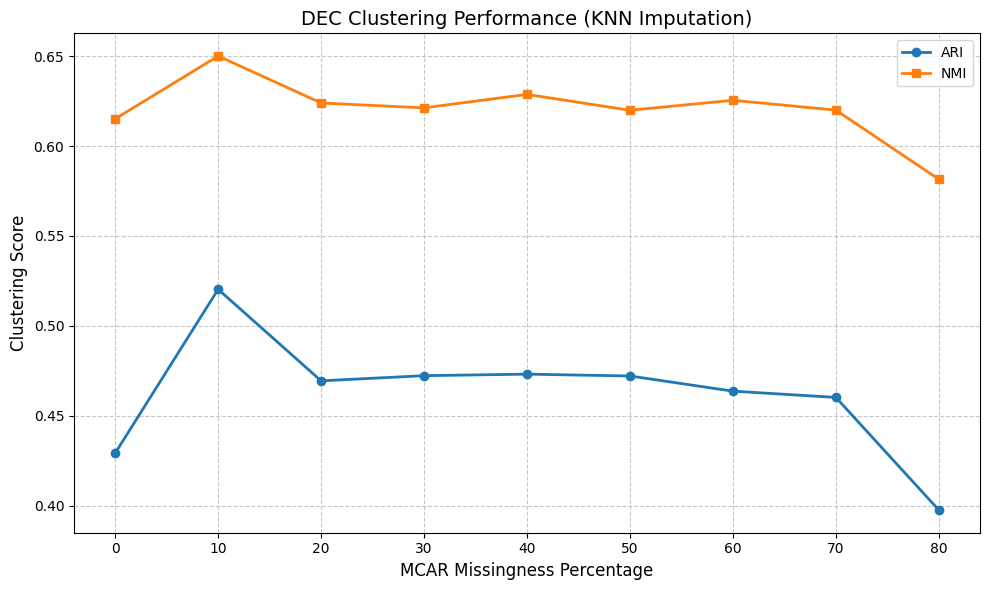

In [13]:
plot_dec_performance(
    missingness_percentages=missingness_percentages,
    score_arrays=[ari_scores_knn, nmi_scores_knn],
    labels=['ARI', 'NMI'],
    title='DEC Clustering Performance (KNN Imputation)'
)

# Mean imputation

In [14]:
ari_scores_mean = []
nmi_scores_mean = []
missingness_percentages = np.arange(0, 100, 10)

In [ ]:
for mcar_percent in missingness_percentages:
    missing_rate_float = mcar_percent / 100.0
    print(f"\n--- Testing Missingness {mcar_percent}% ---")

    X_missing_flat, _ = missingness.apply_corruption(
        tensor_x,
        corruption_type='mcar',
        missing_rate=missing_rate_float
    )

    X_missing_image = X_missing_flat.view(-1, 1, H_W, H_W)
    X_imputed_image = mean_impute_image(X_missing_image)
    X_imputed_flat = X_imputed_image.view(-1, N_FEATURES)

    ari, nmi = run_dec_pipeline(
        X_imputed_flat,
        labels,
        indices,
        device=device,
        ae_epochs=15,
        dec_epochs=55,
        n_clusters=10,
        latent_dim=10,
        n_features=784,
    )

    ari_scores_mean.append(ari)
    nmi_scores_mean.append(nmi)

    print(f"\nPercentage ({mcar_percent}% MCAR): ARI={ari:.4f} | NMI={nmi:.4f}")


--- Testing Missingness 0% ---


In [19]:
results_df = pd.DataFrame({
    'Missingness': missingness_percentages,
    'ARI (Mean-DEC)': ari_scores_mean,
    'NMI (Mean-DEC)': nmi_scores_mean
})

print(results_df)

   Missingness  ARI (Mean-DEC)  NMI (Mean-DEC)
0            0        0.423207        0.592692
1           10        0.460755        0.620059
2           20        0.449884        0.628895
3           30        0.474416        0.652100
4           40        0.407276        0.579847
5           50        0.476616        0.613999
6           60        0.472158        0.595128
7           70        0.396192        0.534177
8           80        0.314078        0.450629
9           90        0.156222        0.274077


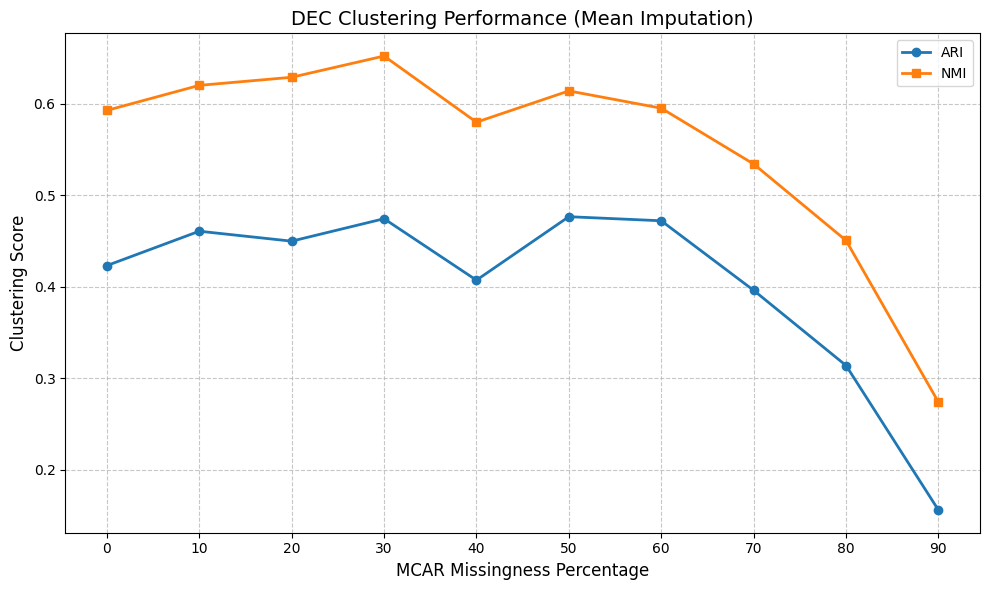

In [20]:
plot_dec_performance(
    missingness_percentages=missingness_percentages,
    score_arrays=[ari_scores_mean, nmi_scores_mean],
    labels=['ARI', 'NMI'],
    title='DEC Clustering Performance (Mean Imputation)'
)

# Denoising Autoencoder